In [1]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
import pandas as pd
import numpy as np
import gc

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import psutil
import os

def get_memory_usage_mb():
    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss  # 현재 프로세스의 실제 메모리 사용량
    return mem_bytes / 1024 ** 2  # MB 단위로 변환

In [4]:
import pandas as pd
import gc

class CARD_container():
    def __init__(self):
        self.data_splits = ["train", "test"]
        self.data_categories = {
            "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
            "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
            "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
            "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
            "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
            "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
            "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
            "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
        }
        self.months = ['07', '08', '09', '10', '11', '12']
        self.data = {}       
        self.train_data = {} 
        self.test_data = {}  
    @staticmethod
    def get_memory_usage_mb():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 ** 2
        


    def load_final_data(self, train_path=None, test_path=None):
        """train_final, test_final 데이터를 불러오는 메서드"""
        if train_path:
            df = pd.read_parquet(train_path)
            self.train_data = {'train_merged_all': df}
            print(f"✅ train_final.parquet 로딩 완료, shape: {df.shape}")

        if test_path:
            df = pd.read_parquet(test_path)
            self.test_data = {'test_merged_all': df}
            print(f"✅ test_final.parquet 로딩 완료, shape: {df.shape}")
        
    def get_data(self, path='/home/cksgh8511/키움/card', months=['07'], data_splits=["train", "test"]):
        for split in data_splits:
            for category, info in self.data_categories.items():
                folder = info["folder"]
                suffix = info["suffix"]
                var_prefix = info["var_prefix"]

                for month in months:
                    file_path = f"{path}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
                    variable_name = f"{var_prefix}_{split}_{month}"

                    try:
                        if split == 'train':
                            self.train_data[variable_name] = pd.read_parquet(file_path)
                            print(f"{variable_name} is loaded from {file_path}")
                        elif split == 'test':
                            self.test_data[variable_name] = pd.read_parquet(file_path)
                            print(f"{variable_name} is loaded from {file_path}")
                    except Exception as e:
                        print(f"Failed to load {file_path}: {e}")

        gc.collect()

    def merge_train_data(self, months=None):
        """여러 month에 대해 train 데이터 통합"""
        if months is None:
            months = self.months  # default: ['07', ..., '12']

        for month in months:
            print(f"\n🛠️ [Train] {month}월 데이터 통합 시작")

            self.get_memory_usage_mb()

            customer_key = f'customer_train_{month}'
            credit_key = f'credit_train_{month}'

            if customer_key not in self.train_data or credit_key not in self.train_data:
                print(f"❗ {customer_key} 또는 {credit_key}가 없습니다. 스킵합니다.")
                continue

            train_df = self.train_data[customer_key].merge(
                self.train_data[credit_key], on=['기준년월', 'ID'], how='left'
            )
            print(f"Step1 저장 완료: {customer_key} + {credit_key}, shape: {train_df.shape}")

            del self.train_data[customer_key]
            del self.train_data[credit_key]
            gc.collect()

            merge_sequence = [
                ("sales", "Step2"),
                ("billing", "Step3"),
                ("balance", "Step4"),
                ("channel", "Step5"),
                ("marketing", "Step6"),
                ("performance", "최종")
            ]

            for prefix, step_name in merge_sequence:
                df_key = f'{prefix}_train_{month}'

                if df_key not in self.train_data:
                    print(f"Warning: {df_key} 없음. {step_name} 단계 스킵.")
                    continue

                train_df = train_df.merge(
                    self.train_data[df_key], on=['기준년월', 'ID'], how='left'
                )
                print(f"{step_name} 저장 완료: merge {df_key}, shape: {train_df.shape}")

                del self.train_data[df_key]
                gc.collect()

            self.get_memory_usage_mb()

            self.train_data[f'train_merged_{month}'] = train_df
            print(f"✅ 최종 통합 완료: train_merged_{month}, shape: {train_df.shape}")

    def merge_test_data(self, months=None):
        """여러 month에 대해 test 데이터 통합"""
        if months is None:
            months = self.months

        for month in months:
            print(f"\n🛠️ [Test] {month}월 데이터 통합 시작")

            self.get_memory_usage_mb()

            customer_key = f'customer_test_{month}'
            credit_key = f'credit_test_{month}'

            if customer_key not in self.test_data or credit_key not in self.test_data:
                print(f"❗ {customer_key} 또는 {credit_key}가 없습니다. 스킵합니다.")
                continue

            test_df = self.test_data[customer_key].merge(
                self.test_data[credit_key], on=['기준년월', 'ID'], how='left'
            )
            print(f"Step1 저장 완료: {customer_key} + {credit_key}, shape: {test_df.shape}")

            del self.test_data[customer_key]
            del self.test_data[credit_key]
            gc.collect()

            merge_sequence = [
                ("sales", "Step2"),
                ("billing", "Step3"),
                ("balance", "Step4"),
                ("channel", "Step5"),
                ("marketing", "Step6"),
                ("performance", "최종")
            ]

            for prefix, step_name in merge_sequence:
                df_key = f'{prefix}_test_{month}'

                if df_key not in self.test_data:
                    print(f"Warning: {df_key} 없음. {step_name} 단계 스킵.")
                    continue

                test_df = test_df.merge(
                    self.test_data[df_key], on=['기준년월', 'ID'], how='left'
                )
                print(f"{step_name} 저장 완료: merge {df_key}, shape: {test_df.shape}")

                del self.test_data[df_key]
                gc.collect()

            self.get_memory_usage_mb()

            self.test_data[f'test_merged_{month}'] = test_df
            print(f"✅ 최종 통합 완료: test_merged_{month}, shape: {test_df.shape}")
    
    def concat_merged_train_data(self, months=None):
        """여러 월의 train_merged 데이터프레임을 하나로 통합"""
        if months is None:
            months = self.months

        dfs = []
        for month in months:
            key = f"train_merged_{month}"
            if key in self.train_data:
                dfs.append(self.train_data[key])
            else:
                print(f"⚠️ {key} 없음. 스킵합니다.")

        if not dfs:
            print("❌ 병합할 데이터가 없습니다.")
            return None

        full_df = pd.concat(dfs, axis=0, ignore_index=True)
        self.train_data['train_merged_all'] = full_df
        print(f"\n🎯 전체 통합 완료: train_merged_all, shape: {full_df.shape}")
        return full_df   
    
    def concat_merged_test_data(self, months=None):
        """여러 월의 test_merged 데이터프레임을 하나로 통합"""
        if months is None:
            months = self.months

        dfs = []
        for month in months:
            key = f"test_merged_{month}"
            if key in self.test_data:
                dfs.append(self.test_data[key])
            else:
                print(f"⚠️ {key} 없음. 스킵합니다.")

        if not dfs:
            print("❌ 병합할 test 데이터가 없습니다.")
            return None

        full_df = pd.concat(dfs, axis=0, ignore_index=True)
        self.test_data['test_merged_all'] = full_df
        print(f"\n🎯 전체 통합 완료: test_merged_all, shape: {full_df.shape}")
        return full_df
    

In [5]:
import pandas as pd

class CARD_EDA():
    def __init__(self, card_container):
        self.card_container = card_container
        self.data_types = ['customer','credit', 'sales', 'billing', 'balance', 'channel', 'marketing', 'performance']

    

    def get_columns(self, dfs='train'):

        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        for name, df in dfs.items():
            print(f"\n[{name} 컬럼 목록] ({df.shape[1]} columns)")
            print(df.columns.tolist())

    def print_unique(self, dfs='train', drop=True):
        def get_unique_info_for_df(series):
            value_counts = series.value_counts(dropna=False)
            return pd.Series({
                'n_unique': series.nunique(dropna=False),
                'value_counts': value_counts.to_dict()
            })

        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        for key, value in self.constant_features_dict.items():
            
            result_df = dfs[key][value].apply(get_unique_info_for_df).T
            print(key)
            if result_df.empty:
                print("Empty ")
            else:
                print(result_df)

    def get_constant_feature(self, dfs='train', drop=False):
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        constant_features_dict = {}

        for name, df in dfs.items():
            constant_features = [
                col for col in df.columns
                if df[col].nunique(dropna=False) <= 1 and col != '기준년월'
            ]
            constant_features_dict[name] = constant_features
            if drop:
                df.drop(columns=constant_features, inplace=True)

            print(f"[{name}] 상수 feature 개수 (기준년월 제외): {len(constant_features)}개")
            if constant_features:
                print(" -", constant_features)
            else:
                print(" - 없음")

        self.constant_features_dict = constant_features_dict
    
    def get_date_features(self, dfs='train', drop=False):
        """ 날짜형 feature를 찾아 제거하는 메서드 """
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        date_features_dict = {}

        for name, df in dfs.items():
            date_features = [
                col for col in df.columns
                if (pd.api.types.is_datetime64_any_dtype(df[col]) or 'date' in col.lower() or '일자' in col)
            ]
            date_features_dict[name] = date_features
            if drop:
                df.drop(columns=date_features, inplace=True)

            print(f"[{name}] 날짜형 feature 개수: {len(date_features)}개")
            if date_features:
                print(" -", date_features)
            else:
                print(" - 없음")

        self.date_features_dict = date_features_dict

    def get_high_single_value_features(self, dfs='train', threshold=0.95, drop=False):
        """ 결측치 또는 단일값이 95% 이상인 feature 제거하는 메서드 """
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        high_single_value_features_dict = {}

        for name, df in dfs.items():
            high_single_features = []

            for col in df.columns:
                if df[col].isna().mean() >= threshold:
                    high_single_features.append(col)
                else:
                    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
                    if top_freq >= threshold:
                        high_single_features.append(col)

            high_single_value_features_dict[name] = high_single_features

            if drop:
                df.drop(columns=high_single_features, inplace=True)

            print(f"[{name}] 95% 이상 결측/단일값 feature 개수: {len(high_single_features)}개")
            if high_single_features:
                print(" -", high_single_features)
            else:
                print(" - 없음")

        self.high_single_value_features_dict = high_single_value_features_dict


In [6]:
card_container = CARD_container()

# 기존 get_data()는 아예 안 쓰고
card_container.load_final_data(
    train_path="/home/cksgh8511/키움/card/train_final.parquet",
    test_path="/home/cksgh8511/키움/card/test_final.parquet"
)

# 이후 EDA 시작
card_eda = CARD_EDA(card_container)

card_eda.get_columns(dfs='train')
card_eda.get_constant_feature(dfs='train')

✅ train_final.parquet 로딩 완료, shape: (2400000, 858)
✅ test_final.parquet 로딩 완료, shape: (600000, 857)

[train_merged_all 컬럼 목록] (858 columns)
['기준년월', 'ID', '남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수', '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product
from xgboost.callback import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class XGBModelManager:
    def __init__(self, df, target_col, drop_cols=None, test_size=0.2, random_state=42, pre=True):
        self.df = df.copy()
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else ['기준년월', 'ID']
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.model = None
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.evals_result = None

        self.pca = None
        self.X_train_pca = None
        self.X_val_pca = None
        self.X_test_pca = None

        if pre:
            self._prepare_data()

    def _prepare_data(self):
        X = self.df.drop(columns=self.drop_cols + [self.target_col])
        y = self.df[self.target_col]

        for col in X.columns:
            if X[col].dtype == 'object':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le

        le_y = LabelEncoder()
        y = le_y.fit_transform(y)
        self.label_encoders[self.target_col] = le_y

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )
        print(f"✅ 데이터 분리 완료: X_train {self.X_train.shape}, X_val {self.X_val.shape}")

    def apply_pca(self, n_components=50):
        print("⚙️ NaN 포함 feature 제거 및 PCA 적용 중...")

        # NaN이 하나라도 있는 컬럼 제거
        nan_cols = self.X_train.columns[self.X_train.isna().any()]
        self.X_train = self.X_train.drop(columns=nan_cols)
        self.X_val = self.X_val.drop(columns=nan_cols)

        print(f"🧹 제거된 NaN 포함 feature 수: {len(nan_cols)}개")

        # 정규화
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_val_scaled = scaler.transform(self.X_val)

        # PCA
        pca = PCA(n_components=n_components, random_state=self.random_state)
        self.X_train_pca = pca.fit_transform(X_train_scaled)
        self.X_val_pca = pca.transform(X_val_scaled)

        self.pca = pca
        self.scaler = scaler
        print(f"✅ PCA 완료 → 차원수: {n_components}")
    
    def transform_test_with_pca(self, X_test):
        X_test_scaled = self.scaler.transform(X_test)
        self.X_test_pca = self.pca.transform(X_test_scaled)
        return self.X_test_pca

    def train_model(self, features=None, early_stopping_rounds=30, grid_search=False, param_grid=None, params=None, use_pca=False):
        if use_pca:
            X_train = self.X_train_pca
            X_val = self.X_val_pca
        elif features is not None:
            X_train = self.X_train[features]
            X_val = self.X_val[features]
            self.selected_features = features
        else:
            X_train = self.X_train
            X_val = self.X_val
            self.selected_features = X_train.columns.tolist()

        base_params = {
            'tree_method': 'hist',
            'max_bin': 256,
            'random_state': self.random_state,
            'eval_metric': 'mlogloss'
        }
        if params:
            base_params.update(params)

        if not grid_search:
            self.model = xgb.XGBClassifier(**base_params)
            self.model.fit(
                X_train, self.y_train,
                eval_set=[(X_train, self.y_train), (X_val, self.y_val)],
                verbose=True
            )
            self.evals_result = self.model.evals_result()
            print(f"✅ 모델 학습 완료 (features: {'PCA' if use_pca else features if features else '전체'})")
        else:
            print("🚀 그리디 서치 시작...")
            best_score = float('inf')
            best_params = None
            best_model = None

            keys = list(param_grid.keys())
            for values in product(*param_grid.values()):
                trial_params = dict(zip(keys, values))
                trial_params.update(base_params)

                model = xgb.XGBClassifier(**trial_params)
                model.fit(
                    X_train, self.y_train,
                    eval_set=[(X_train, self.y_train), (X_val, self.y_val)],
                    verbose=False
                )
                evals_result = model.evals_result()
                val_score = evals_result['validation_1']['mlogloss'][-1]

                print(f"🔍 Tried {trial_params} → val_mlogloss = {val_score:.5f}")

                if val_score < best_score:
                    best_score = val_score
                    best_params = trial_params
                    best_model = model

            self.model = best_model
            self.evals_result = best_model.evals_result()
            self.best_params = best_params
            print(f"✅ Best params found: {best_params}")
            print(f"✅ Best validation mlogloss: {best_score:.5f}")

    def plot_loss(self):
        if not self.evals_result:
            print("❗ 학습 결과가 없습니다. 먼저 모델을 학습하세요.")
            return

        train_loss = self.evals_result['validation_0']['mlogloss']
        val_loss = self.evals_result['validation_1']['mlogloss']

        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Train Loss (mlogloss)')
        plt.plot(val_loss, label='Validation Loss (mlogloss)')
        plt.xlabel('Iteration')
        plt.ylabel('Log Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_feature_importance(self, max_num_features=20):
        if not self.model:
            print("❗ 모델이 없습니다. 먼저 학습하세요.")
            return

        xgb.plot_importance(
            self.model,
            max_num_features=max_num_features,
            importance_type='gain',
            height=0.5
        )
        plt.title("Feature Importance")
        plt.grid(True)
        plt.show()

    def evaluate_model(self, use_pca=False):
        if self.model is None:
            print("❗ 모델이 없습니다. 먼저 학습하세요.")
            return

        if use_pca:
            if not hasattr(self, 'X_val_pca'):
                raise ValueError("❗ PCA 적용 전입니다. 먼저 apply_pca()를 호출하고 학습하세요.")
            X_val_selected = self.X_val_pca
        else:
            if not hasattr(self, 'selected_features'):
                raise AttributeError("❗ selected_features가 없습니다. train_model(use_pca=False) 후 사용하세요.")
            X_val_selected = self.X_val[self.selected_features]

        y_pred = self.model.predict(X_val_selected)
        acc = accuracy_score(self.y_val, y_pred)
        f1 = f1_score(self.y_val, y_pred, average='weighted')

        print(f"✅ Accuracy: {acc:.4f}")
        print(f"✅ Weighted F1 Score: {f1:.4f}")
        print("✅ Confusion Matrix:")
        print(confusion_matrix(self.y_val, y_pred))
        
    def get_feature_importance_df(self, importance_type='gain'):
        """Feature Importance를 DataFrame으로 정리해서 중요도 높은 순으로 반환"""
        if self.model is None:
            print("❗ 모델이 없습니다. 먼저 학습하세요.")
            return None

        booster = self.model.get_booster()
        score_dict = booster.get_score(importance_type='gain')
        print(score_dict)

        # f0, f1, f2 → X_train.columns 매핑
        importance_data = []
        for fname, importance in score_dict.items():
            idx = int(fname[1:])  # 'f12' → 12
            col_name = self.X_train.columns[idx]
            importance_data.append((col_name, importance))

        # DataFrame으로 변환
        importance_df = pd.DataFrame(importance_data, columns=['feature', 'importance'])

        # 중요도 높은 순으로 정렬
        importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

        return importance_df


In [20]:
card_container.train_data['train_merged_all'].head()

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0.999998,1.042805,0.999700,0.999998,0.999998,0.261886,0.270752,0.000000,1.044401,1.280543
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,1.092698,0.905663,0.999998,0.999998,0.999998,-0.563388,-0.670348,0.000000,0.000000,0.000000
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,1.006124,1.993590,0.852567,0.999998,0.999998,-0.046516,0.058114,-0.014191,0.524159,1.208420
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0.999998,1.050646,0.999877,0.999998,0.999998,0.023821,0.258943,0.000000,0.880925,1.657124
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN


✅ 데이터 분리 완료: X_train (1920000, 855), X_val (480000, 855)
⚙️ NaN 포함 feature 제거 및 PCA 적용 중...
🧹 제거된 NaN 포함 feature 수: 9개
✅ PCA 완료 → 차원수: 50
[0]	validation_0-mlogloss:1.12820	validation_1-mlogloss:1.12838
[1]	validation_0-mlogloss:0.89307	validation_1-mlogloss:0.89346
[2]	validation_0-mlogloss:0.74489	validation_1-mlogloss:0.74552
[3]	validation_0-mlogloss:0.64418	validation_1-mlogloss:0.64499
[4]	validation_0-mlogloss:0.57312	validation_1-mlogloss:0.57405
[5]	validation_0-mlogloss:0.52193	validation_1-mlogloss:0.52304
[6]	validation_0-mlogloss:0.48420	validation_1-mlogloss:0.48551
[7]	validation_0-mlogloss:0.45606	validation_1-mlogloss:0.45753
[8]	validation_0-mlogloss:0.43477	validation_1-mlogloss:0.43648
[9]	validation_0-mlogloss:0.41820	validation_1-mlogloss:0.42014
[10]	validation_0-mlogloss:0.40539	validation_1-mlogloss:0.40756
[11]	validation_0-mlogloss:0.39524	validation_1-mlogloss:0.39760
[12]	validation_0-mlogloss:0.38691	validation_1-mlogloss:0.38945
[13]	validation_0-mlogloss:

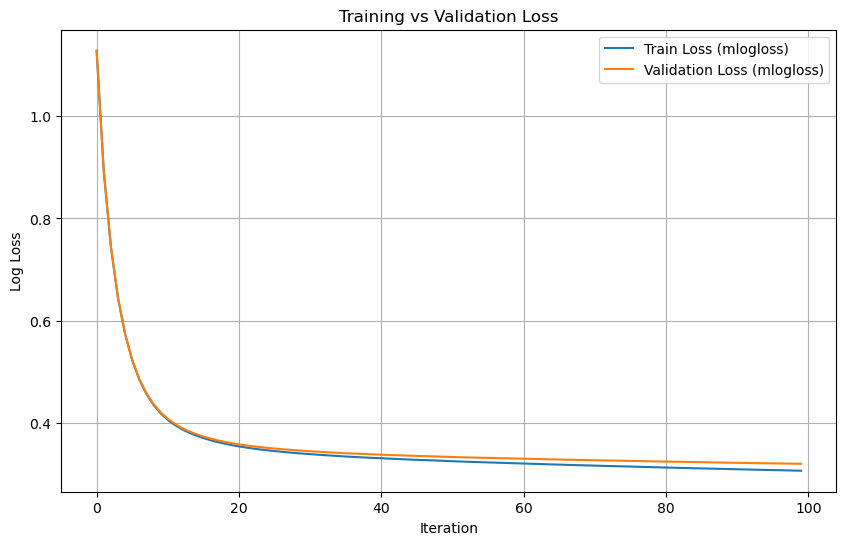

✅ Accuracy: 0.8734
✅ Weighted F1 Score: 0.8659
✅ Confusion Matrix:
[[   100      0     94      0      0]
 [     0     12     17      0      0]
 [     5      0  13102   8574   3837]
 [     0      0   3872  35731  30245]
 [     1      0   1173  12932 370305]]


In [21]:
# 1. 매니저 생성
manager = XGBModelManager(card_container.train_data['train_merged_all'], target_col='Segment')

# 2. 전체 feature로 학습
manager.apply_pca(n_components=50)
manager.train_model(use_pca=True)

manager.plot_loss()
manager.evaluate_model(use_pca=True)  # 꼭 True 설정



In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class SubmissionManager:
    def __init__(self, manager, card_container):
        self.manager = manager
        self.card_container = card_container

    def _encode_object_columns(self, df):
        """
        object 타입 컬럼을 Label Encoding
        """
        for col in df.select_dtypes(include='object').columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        return df

    def predict_and_save(self, test_df_name="test_merged_all", id_column="ID", output_path="./submission.csv", use_pca=False):
        if self.manager.model is None:
            raise ValueError("❗ manager 안에 모델이 없습니다. 먼저 학습하세요.")

        if test_df_name not in self.card_container.test_data:
            raise ValueError(f"❗ card_container.test_data 안에 {test_df_name} 이 없습니다.")

        # 1. test 데이터
        test_df = self.card_container.test_data[test_df_name]

        # 2. feature 선택
        if use_pca:
            if not hasattr(self.manager, 'pca') or not hasattr(self.manager, 'scaler'):
                raise ValueError("❗ PCA 적용 전입니다. 먼저 apply_pca()를 호출하세요.")
            
            # train에서 사용된 feature만 사용
            X_test = test_df[self.manager.X_train.columns.tolist()].copy()
            X_test = self._encode_object_columns(X_test)
            X_test_scaled = self.manager.scaler.transform(X_test)
            X_test = self.manager.pca.transform(X_test_scaled)
        else:
            if hasattr(self.manager, 'selected_features') and self.manager.selected_features is not None:
                X_test = test_df[self.manager.selected_features].copy()
            else:
                X_test = test_df[self.manager.X_train.columns.tolist()].copy()
            X_test = self._encode_object_columns(X_test)

        # 3. 예측
        y_test_pred = self.manager.model.predict(X_test)

        # 4. 디코딩
        y_test_pred_labels = self.manager.label_encoders[self.manager.target_col].inverse_transform(y_test_pred)

        # 5. 결과 추가
        test_data = test_df.copy()
        test_data["pred_label"] = y_test_pred_labels

        # 6. ID 단위로 Voting
        submission = test_data.groupby(id_column)["pred_label"] \
            .agg(lambda x: x.value_counts().idxmax()) \
            .reset_index()

        submission.columns = [id_column, "Segment"]

        # 7. 저장
        submission.to_csv(output_path, index=False)
        print(f"✅ Submission file saved to {output_path}")

        return submission

In [33]:
#  먼저 학습용 매니저에서 PCA 적용 필요
manager.apply_pca(n_components=250)  # 또는 원하는 차원 수

# 이후 PCA로 학습 진행
manager.train_model(use_pca=True)

# PCA 기반 예측 및 저장
submission_manager = SubmissionManager(manager, card_container)
submission_df = submission_manager.predict_and_save(
    test_df_name="test_merged_all",
    id_column="ID",
    output_path="./submission_pca.csv",
    use_pca=True  # PCA 적용
)

⚙️ NaN 포함 feature 제거 및 PCA 적용 중...
🧹 제거된 NaN 포함 feature 수: 0개
✅ PCA 완료 → 차원수: 250
[0]	validation_0-mlogloss:1.12824	validation_1-mlogloss:1.12845
[1]	validation_0-mlogloss:0.89301	validation_1-mlogloss:0.89345
[2]	validation_0-mlogloss:0.74478	validation_1-mlogloss:0.74541
[3]	validation_0-mlogloss:0.64410	validation_1-mlogloss:0.64490
[4]	validation_0-mlogloss:0.57292	validation_1-mlogloss:0.57389
[5]	validation_0-mlogloss:0.52163	validation_1-mlogloss:0.52280
[6]	validation_0-mlogloss:0.48379	validation_1-mlogloss:0.48519
[7]	validation_0-mlogloss:0.45538	validation_1-mlogloss:0.45700
[8]	validation_0-mlogloss:0.43385	validation_1-mlogloss:0.43569
[9]	validation_0-mlogloss:0.41723	validation_1-mlogloss:0.41932
[10]	validation_0-mlogloss:0.40417	validation_1-mlogloss:0.40646
[11]	validation_0-mlogloss:0.39360	validation_1-mlogloss:0.39619
[12]	validation_0-mlogloss:0.38512	validation_1-mlogloss:0.38799
[13]	validation_0-mlogloss:0.37796	validation_1-mlogloss:0.38106
[14]	validation_0-

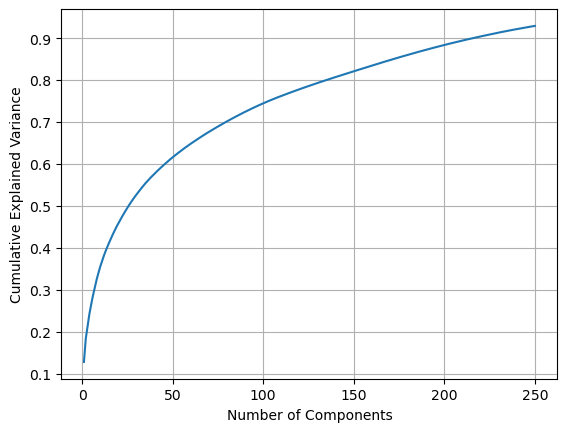

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 설명된 분산 비율 확인
explained = np.cumsum(manager.pca.explained_variance_ratio_)

# 시각화
plt.plot(range(1, len(explained)+1), explained)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()